In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 如果网络的输入数据维度或类型上变化不大，设置可以增加运行效率
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [ ]:
# 下载数据集
dataset = torchvision.datasets.CIFAR10(root="../data", train=True,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


In [ ]:
len(dataset)

50000

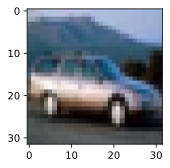

In [ ]:
# 查看数据集中的数据
d2l.set_figsize()
d2l.plt.imshow(dataset[4][0]);

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

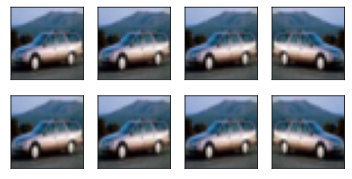

In [ ]:
# 水平翻转
img = dataset[4][0]
apply(img, torchvision.transforms.RandomHorizontalFlip())

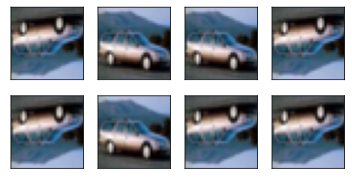

In [ ]:
# 垂直翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

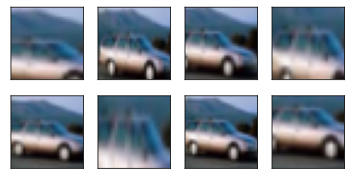

In [ ]:
# 图像拉伸
# scale: 剪裁面积值
# ratio: 高宽比
shape_aug = torchvision.transforms.RandomResizedCrop(
    (30, 30), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

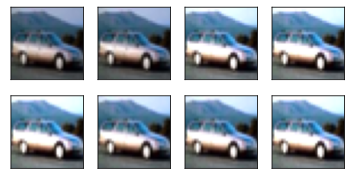

In [ ]:
# 改变亮度、对比度、饱和度与色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

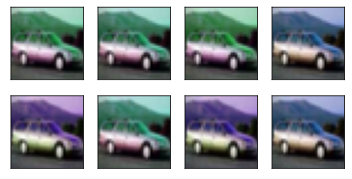

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.2
))

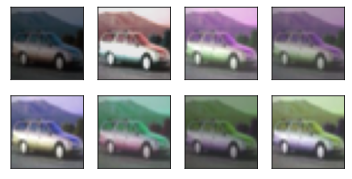

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
))

In [ ]:
# 多种增广方式融合
shape_aug = torchvision.transforms.RandomResizedCrop(
    (30, 30), scale=(0.1, 1), ratio=(0.5, 2)
)
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
augs = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(), shape_aug, color_aug
])


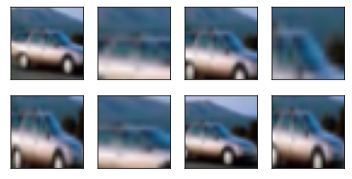

In [ ]:
apply(img, shape_aug)

In [ ]:
# 数据集载入
all_images = torchvision.datasets.CIFAR10(train=True, root="../data")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84721135d0>,
      dtype=object)

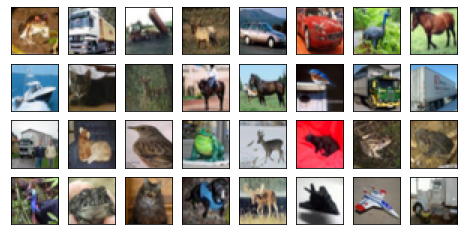

In [ ]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=1.0)

In [ ]:
# 图像数据变换
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [ ]:
def load_cifa10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                         transform=augs, download=True
                                         )
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=is_train, num_workers=d2l.get_dataloader_workers())
  return dataloader
  

In [ ]:
!nvidia-smi

Mon Oct 11 12:26:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train_batch_chp13(net, X, y, loss, trainer, device):
  X = X.to(device)
  y = y.to(device)
  net.train()
  trainer.zero_grad()
  y_hat = net(X)
  l = loss(y_hat, y)
  l.backward()
  trainer.step()

  train_loss_sum = l * len(X)
  train_acc_sum = d2l.accuracy(y_hat, y)
  return train_loss_sum, train_acc_sum

In [ ]:
d2l.try_gpu()

device(type='cuda', index=0)

In [ ]:
def train_chp13(net, train_iter, test_iter, loss, trainer, num_epochs,
                device=d2l.try_gpu()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                          legend=['train loss', 'train acc', 'test acc'])
  # 单GPU无需数据并行
  # net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  net = net.to(device)
  net.apply(init_weights)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_chp13(
          net, features, labels, loss, trainer, device
      )
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                     (metric[0] / metric[2], metric[1] / metric[2],
                     None))
      # 直接用accuracy会报错
      test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
      animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')
        

In [ ]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifa10(True, train_augs, batch_size)
  test_iter = load_cifa10(False, test_augs, batch_size)
  # 单GPU不需要reduction
  # loss = nn.CrossEntropyLoss(reduction="none")
  # 默认mean
  loss = nn.CrossEntropyLoss()
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_chp13(net, train_iter, test_iter, loss, trainer, 5)

In [ ]:
d2l.try_all_gpus()

[device(type='cuda', index=0)]

In [ ]:
train_iter = load_cifa10(True, train_augs, batch_size)
for i, (features, labels) in enumerate(train_iter):
  break

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
type(features)

torch.Tensor

In [ ]:
type(features)

torch.Tensor

In [ ]:
device = d2l.try_gpu()
# features.to(device)

In [ ]:
features.shape

torch.Size([256, 3, 32, 32])

In [ ]:
labels.shape

torch.Size([256])

In [ ]:
batch_size, device, net = 256, d2l.try_gpu(), d2l.resnet18(10, 3)
def init_weights(model):
  if type(model) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_normal_(model.weight)

In [ ]:
# 图像数据变换
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

loss 0.421, train acc 0.853, test acc 0.818
627.0 examples/sec on cuda:0


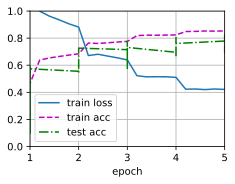

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

In [ ]:
# 运行时间长？